In [ ]:
!pip install -q transformers
!pip install -q timm

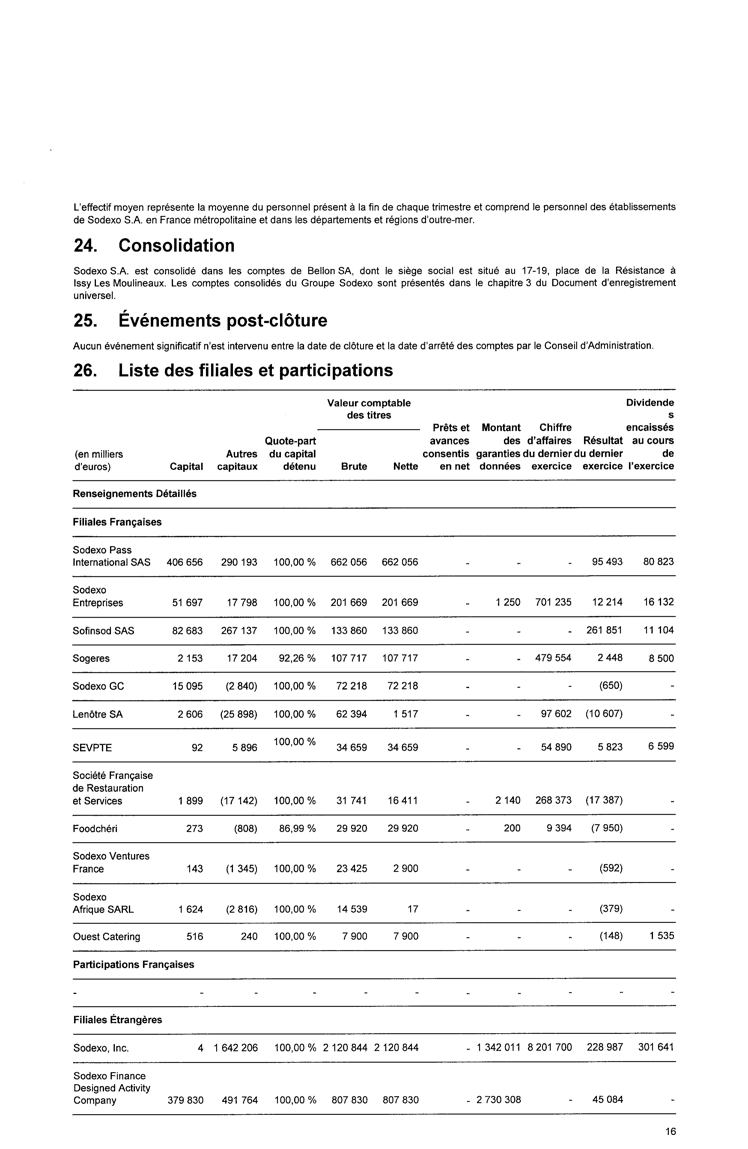

In [1]:

from huggingface_hub import hf_hub_download
from PIL import Image

file_path = "../data/marmot_data/301940219.bmp"
image = Image.open(file_path)
width, height = image.size
image.resize((int(width*0.3), int(height*0.3)))

In [2]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/opt/mamba/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [3]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1228, 800])


In [4]:
from transformers import TableTransformerForObjectDetection
import torch

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
     
with torch.no_grad():
    outputs = model(**encoding)

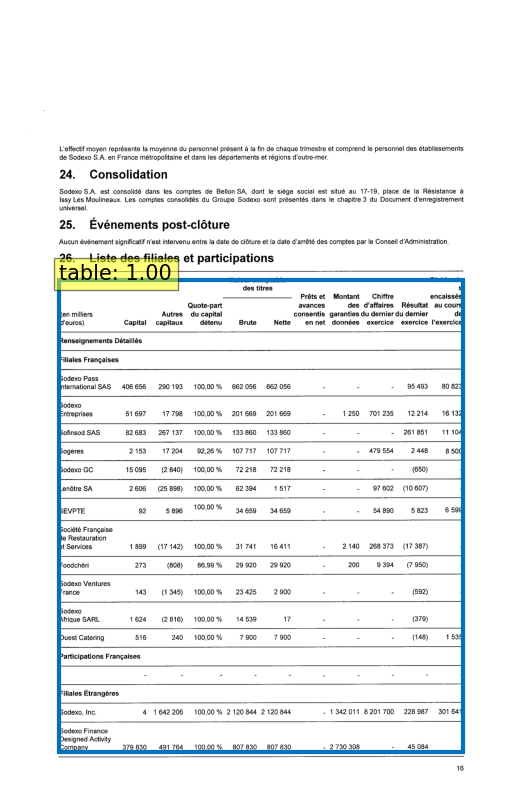

In [5]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

plot_results(image, results['scores'], results['labels'], results['boxes'])

## Structure recognition

In [6]:
xmin, ymin, xmax, ymax = results['boxes'].tolist()[0]

In [7]:
left_padding = 20
top_padding = 50
right_padding = 20
bottom_padding = 50 

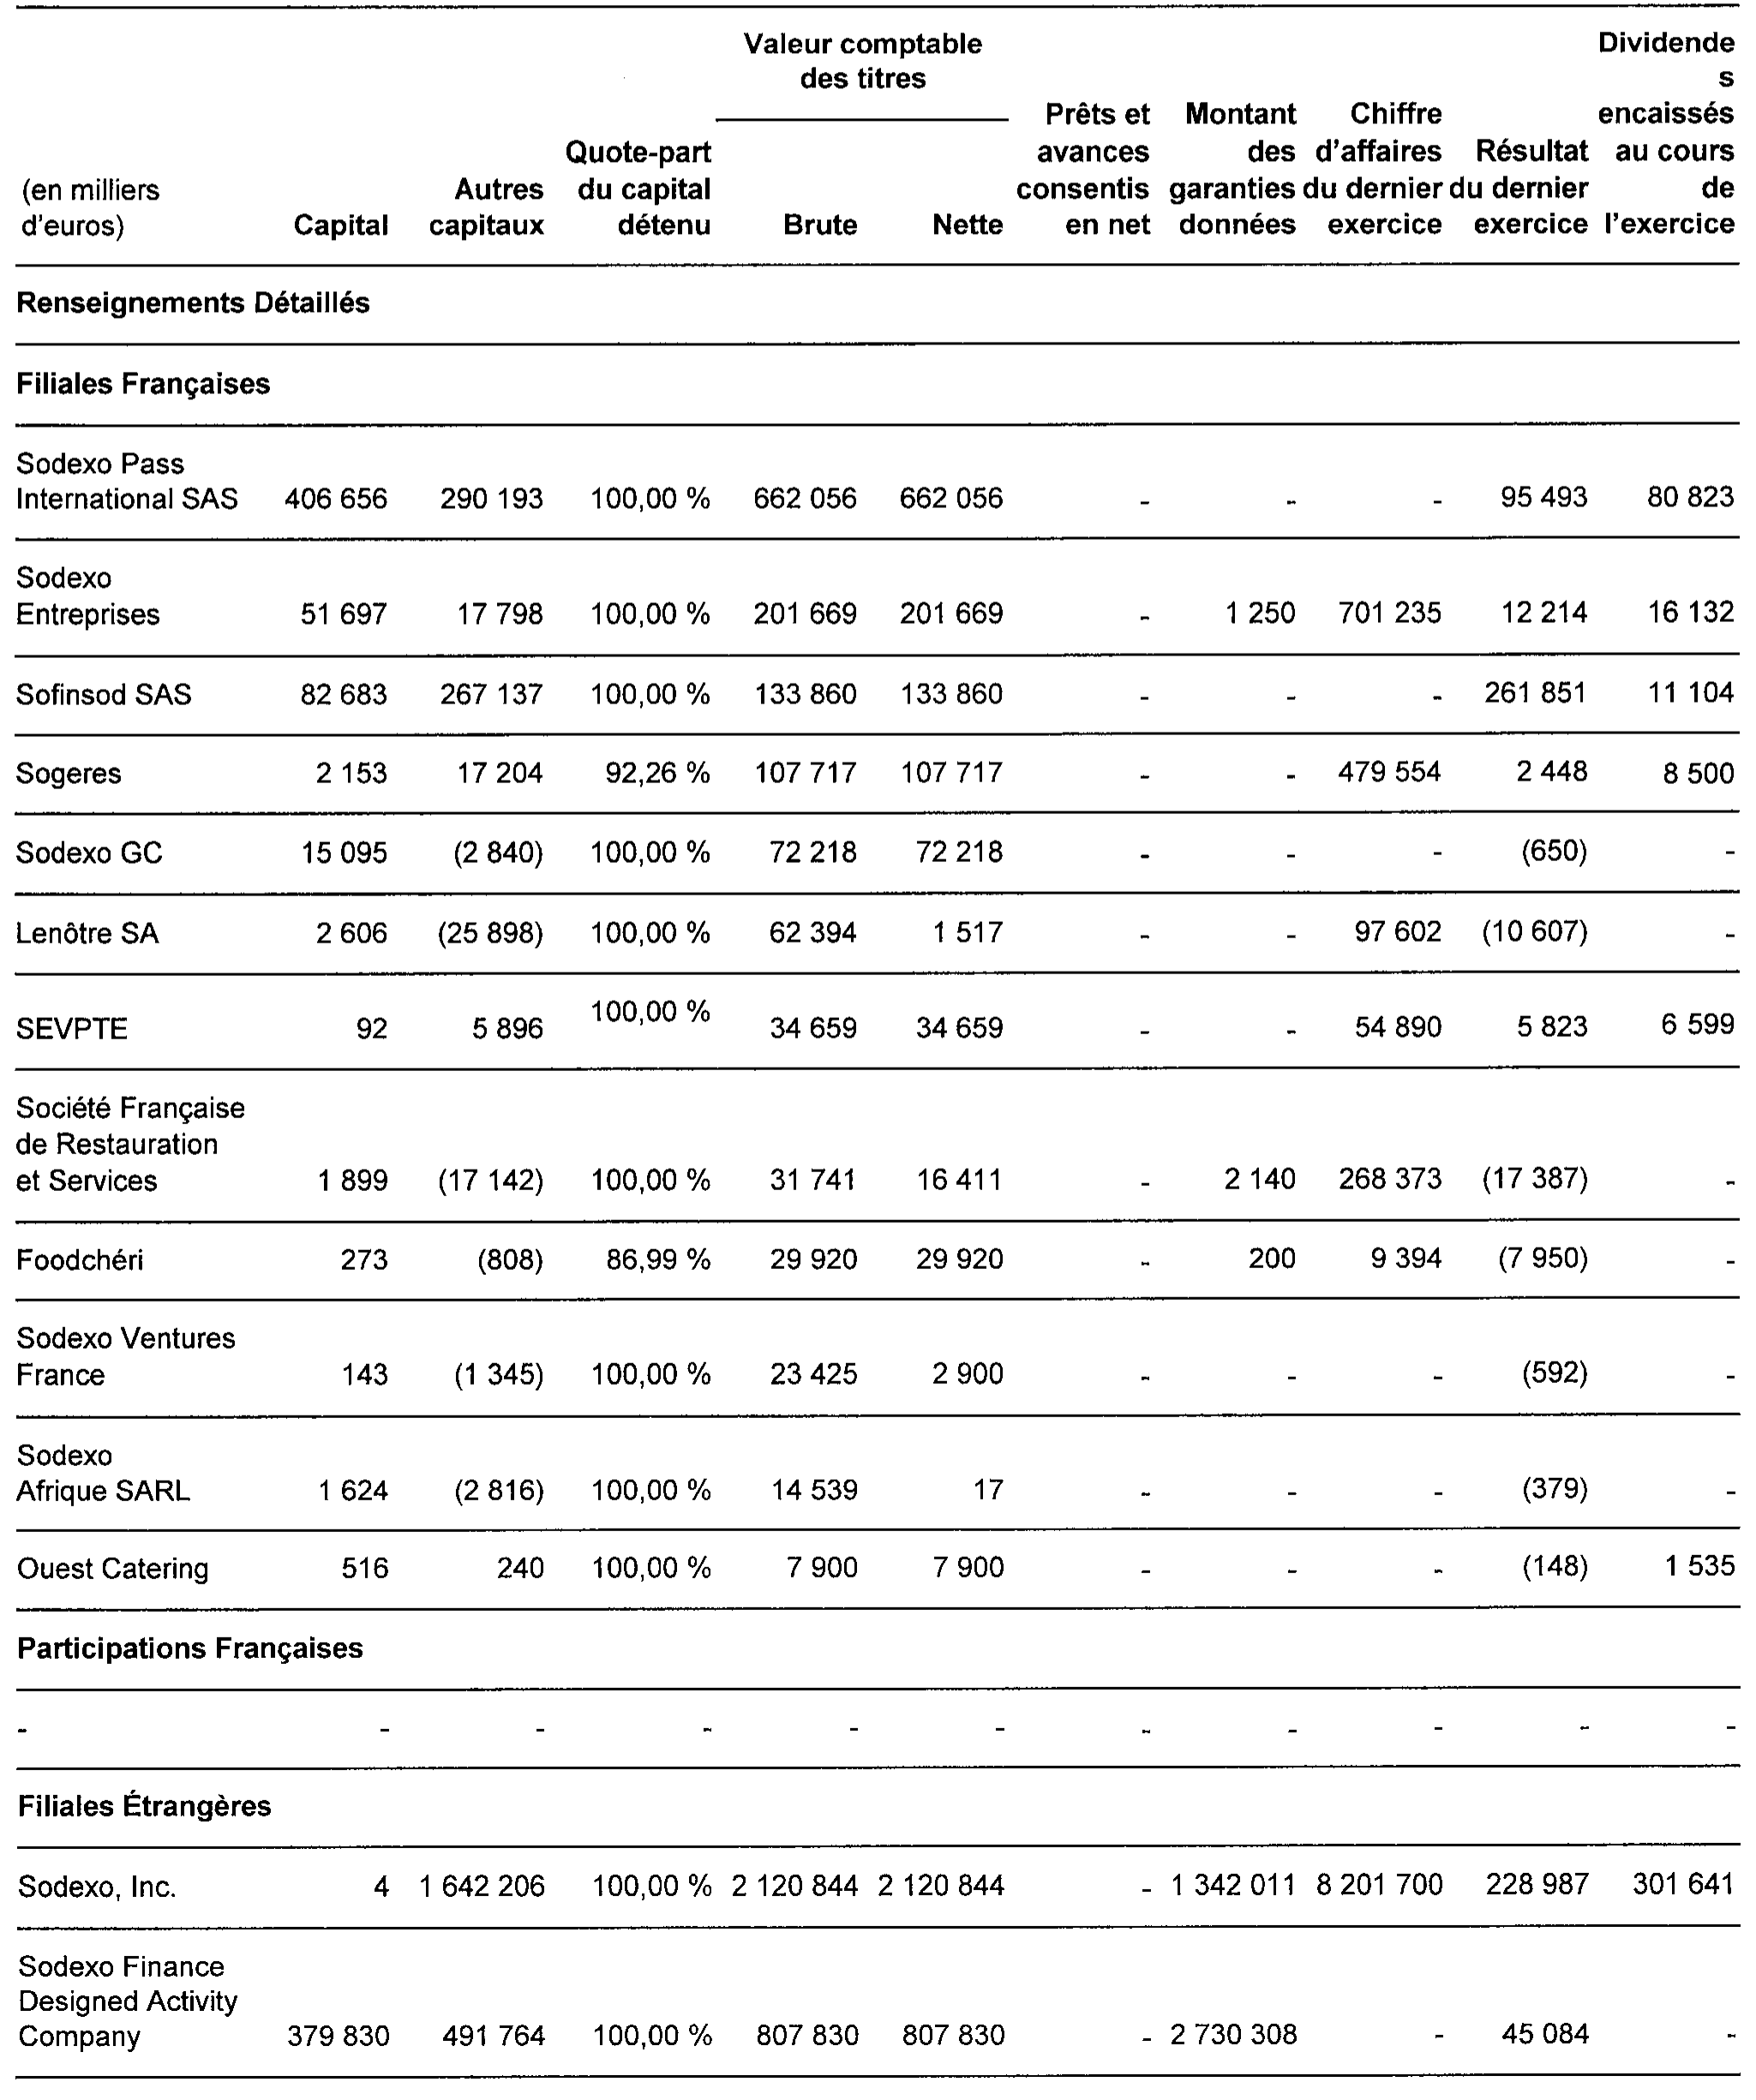

In [8]:
resized_image = image.crop((xmin - right_padding, ymin - top_padding, xmax + right_padding, ymax + bottom_padding))
resized_image

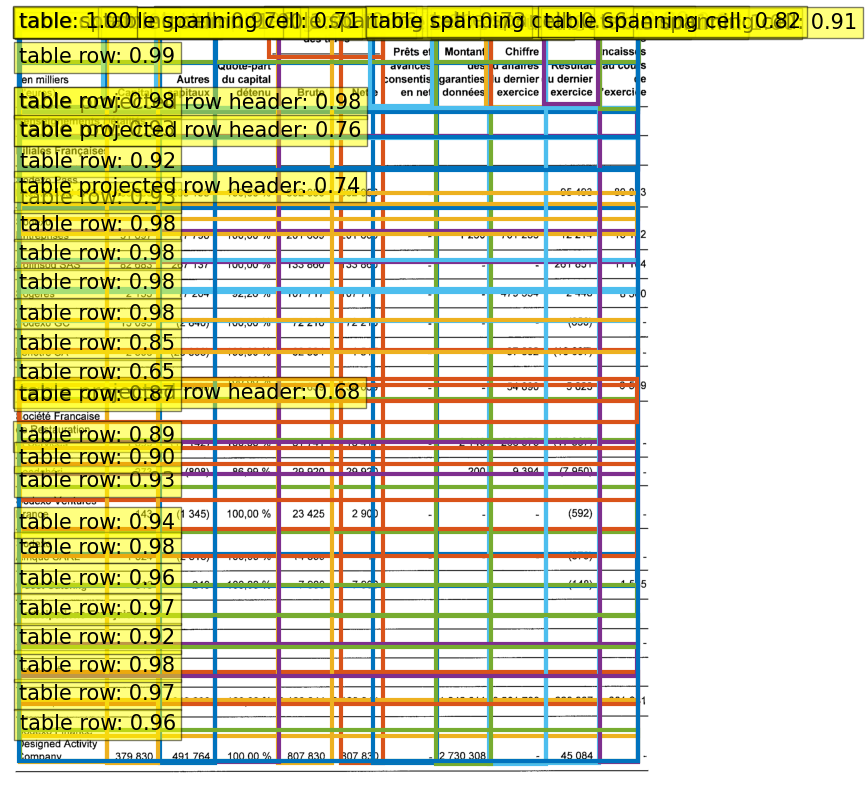

In [9]:
from transformers import TableTransformerForObjectDetection

encoding = feature_extractor(resized_image, return_tensors="pt")
encoding.keys()

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

with torch.no_grad():
  outputs = model(**encoding)
     
target_sizes = [resized_image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(resized_image, results['scores'], results['labels'], results['boxes'])

In [10]:
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [48]:
from fitz import Rect

def iob(bbox1, bbox2):
    """
    Compute the intersection area over box area, for bbox1.
    """
    intersection = Rect(bbox1).intersect(bbox2)
    
    bbox1_area = Rect(bbox1).get_area()
    if bbox1_area > 0:
        return intersection.get_area() / bbox1_area
    
    return 0


def objects_to_structures(objects, tokens, class_thresholds):
    """
    Process the bounding boxes produced by the table structure recognition model into
    a *consistent* set of table structures (rows, columns, spanning cells, headers).
    This entails resolving conflicts/overlaps, and ensuring the boxes meet certain alignment
    conditions (for example: rows should all have the same width, etc.).
    """

    tables = [obj for obj in objects if obj['label'] == 'table']
    table_structures = []

    for table in tables:
        table_objects = [obj for obj in objects if iob(obj['bbox'], table['bbox']) >= 0.5]
        table_tokens = [token for token in tokens if iob(token['bbox'], table['bbox']) >= 0.5]
        
        structure = {}

        columns = [obj for obj in table_objects if obj['label'] == 'table column']
        rows = [obj for obj in table_objects if obj['label'] == 'table row']
        column_headers = [obj for obj in table_objects if obj['label'] == 'table column header']
        spanning_cells = [obj for obj in table_objects if obj['label'] == 'table spanning cell']
        for obj in spanning_cells:
            obj['projected row header'] = False
        projected_row_headers = [obj for obj in table_objects if obj['label'] == 'table projected row header']
        for obj in projected_row_headers:
            obj['projected row header'] = True
        spanning_cells += projected_row_headers
        for obj in rows:
            obj['column header'] = False
            for header_obj in column_headers:
                if iob(obj['bbox'], header_obj['bbox']) >= 0.5:
                    obj['column header'] = True

        # Refine table structures
        rows = refine_rows(rows, table_tokens, class_thresholds['table row'])
        columns = refine_columns(columns, table_tokens, class_thresholds['table column'])

        # Shrink table bbox to just the total height of the rows
        # and the total width of the columns
        row_rect = Rect()
        for obj in rows:
            row_rect.include_rect(obj['bbox'])
        column_rect = Rect() 
        for obj in columns:
            column_rect.include_rect(obj['bbox'])
        table['row_column_bbox'] = [column_rect[0], row_rect[1], column_rect[2], row_rect[3]]
        table['bbox'] = table['row_column_bbox']

        # Process the rows and columns into a complete segmented table
        columns = align_columns(columns, table['row_column_bbox'])
        rows = align_rows(rows, table['row_column_bbox'])

        structure['rows'] = rows
        structure['columns'] = columns
        structure['column headers'] = column_headers
        structure['spanning cells'] = spanning_cells

        if len(rows) > 0 and len(columns) > 1:
            structure = refine_table_structure(structure, class_thresholds)

        table_structures.append(structure)

    return table_structures

In [49]:
def structure_to_cells(table_structure, tokens):
    """
    Assuming the row, column, spanning cell, and header bounding boxes have
    been refined into a set of consistent table structures, process these
    table structures into table cells. This is a universal representation
    format for the table, which can later be exported to Pandas or CSV formats.
    Classify the cells as header/access cells or data cells
    based on if they intersect with the header bounding box.
    """
    columns = table_structure['columns']
    rows = table_structure['rows']
    spanning_cells = table_structure['spanning cells']
    cells = []
    subcells = []

    # Identify complete cells and subcells
    for column_num, column in enumerate(columns):
        for row_num, row in enumerate(rows):
            column_rect = Rect(list(column['bbox']))
            row_rect = Rect(list(row['bbox']))
            cell_rect = row_rect.intersect(column_rect)
            header = 'column header' in row and row['column header']
            cell = {'bbox': list(cell_rect), 'column_nums': [column_num], 'row_nums': [row_num],
                    'column header': header}

            cell['subcell'] = False
            for spanning_cell in spanning_cells:
                spanning_cell_rect = Rect(list(spanning_cell['bbox']))
                if (spanning_cell_rect.intersect(cell_rect).get_area()
                        / cell_rect.get_area()) > 0.5:
                    cell['subcell'] = True
                    break

            if cell['subcell']:
                subcells.append(cell)
            else:
                #cell text = extract_text_inside_bbox(table_spans, cell['bbox'])
                #cell['cell text'] = cell text
                cell['projected row header'] = False
                cells.append(cell)

    for spanning_cell in spanning_cells:
        spanning_cell_rect = Rect(list(spanning_cell['bbox']))
        cell_columns = set()
        cell_rows = set()
        cell_rect = None
        header = True
        for subcell in subcells:
            subcell_rect = Rect(list(subcell['bbox']))
            subcell_rect_area = subcell_rect.get_area()
            if (subcell_rect.intersect(spanning_cell_rect).get_area()
                    / subcell_rect_area) > 0.5:
                if cell_rect is None:
                    cell_rect = Rect(list(subcell['bbox']))
                else:
                    cell_rect.include_rect(Rect(list(subcell['bbox'])))
                cell_rows = cell_rows.union(set(subcell['row_nums']))
                cell_columns = cell_columns.union(set(subcell['column_nums']))
                # By convention here, all subcells must be classified
                # as header cells for a spanning cell to be classified as a header cell;
                # otherwise, this could lead to a non-rectangular header region
                header = header and 'column header' in subcell and subcell['column header']
        if len(cell_rows) > 0 and len(cell_columns) > 0:
            cell = {'bbox': list(cell_rect), 'column_nums': list(cell_columns), 'row_nums': list(cell_rows),
                    'column header': header, 'projected row header': spanning_cell['projected row header']}
            cells.append(cell)

    # Compute a confidence score based on how well the page tokens
    # slot into the cells reported by the model
    _, _, cell_match_scores = slot_into_containers(cells, tokens)
    try:
        mean_match_score = sum(cell_match_scores) / len(cell_match_scores)
        min_match_score = min(cell_match_scores)
        confidence_score = (mean_match_score + min_match_score)/2
    except:
        confidence_score = 0

    # Dilate rows and columns before final extraction
    #dilated_columns = fill_column_gaps(columns, table_bbox)
    dilated_columns = columns
    #dilated_rows = fill_row_gaps(rows, table_bbox)
    dilated_rows = rows
    for cell in cells:
        column_rect = Rect()
        for column_num in cell['column_nums']:
            column_rect.include_rect(list(dilated_columns[column_num]['bbox']))
        row_rect = Rect()
        for row_num in cell['row_nums']:
            row_rect.include_rect(list(dilated_rows[row_num]['bbox']))
        cell_rect = column_rect.intersect(row_rect)
        cell['bbox'] = list(cell_rect)

    span_nums_by_cell, _, _ = slot_into_containers(cells, tokens, overlap_threshold=0.001,
                                                               unique_assignment=True, forced_assignment=False)

    for cell, cell_span_nums in zip(cells, span_nums_by_cell):
        cell_spans = [tokens[num] for num in cell_span_nums]
        # TODO: Refine how text is extracted; should be character-based, not span-based;
        # but need to associate 
        cell['cell text'] = extract_text_from_spans(cell_spans, remove_integer_superscripts=False)
        cell['spans'] = cell_spans
        
    # Adjust the row, column, and cell bounding boxes to reflect the extracted text
    num_rows = len(rows)
    rows = sort_objects_top_to_bottom(rows)
    num_columns = len(columns)
    columns = sort_objects_left_to_right(columns)
    min_y_values_by_row = defaultdict(list)
    max_y_values_by_row = defaultdict(list)
    min_x_values_by_column = defaultdict(list)
    max_x_values_by_column = defaultdict(list)
    for cell in cells:
        min_row = min(cell["row_nums"])
        max_row = max(cell["row_nums"])
        min_column = min(cell["column_nums"])
        max_column = max(cell["column_nums"])
        for span in cell['spans']:
            min_x_values_by_column[min_column].append(span['bbox'][0])
            min_y_values_by_row[min_row].append(span['bbox'][1])
            max_x_values_by_column[max_column].append(span['bbox'][2])
            max_y_values_by_row[max_row].append(span['bbox'][3])
    for row_num, row in enumerate(rows):
        if len(min_x_values_by_column[0]) > 0:
            row['bbox'][0] = min(min_x_values_by_column[0])
        if len(min_y_values_by_row[row_num]) > 0:
            row['bbox'][1] = min(min_y_values_by_row[row_num])
        if len(max_x_values_by_column[num_columns-1]) > 0:
            row['bbox'][2] = max(max_x_values_by_column[num_columns-1])
        if len(max_y_values_by_row[row_num]) > 0:
            row['bbox'][3] = max(max_y_values_by_row[row_num])
    for column_num, column in enumerate(columns):
        if len(min_x_values_by_column[column_num]) > 0:
            column['bbox'][0] = min(min_x_values_by_column[column_num])
        if len(min_y_values_by_row[0]) > 0:
            column['bbox'][1] = min(min_y_values_by_row[0])
        if len(max_x_values_by_column[column_num]) > 0:
            column['bbox'][2] = max(max_x_values_by_column[column_num])
        if len(max_y_values_by_row[num_rows-1]) > 0:
            column['bbox'][3] = max(max_y_values_by_row[num_rows-1])
    for cell in cells:
        row_rect = Rect()
        column_rect = Rect()
        for row_num in cell['row_nums']:
            row_rect.include_rect(list(rows[row_num]['bbox']))
        for column_num in cell['column_nums']:
            column_rect.include_rect(list(columns[column_num]['bbox']))
        cell_rect = row_rect.intersect(column_rect)
        if cell_rect.get_area() > 0:
            cell['bbox'] = list(cell_rect)
            pass

    return cells, confidence_score

def cells_to_csv(cells):
    if len(cells) > 0:
        num_columns = max([max(cell['column_nums']) for cell in cells]) + 1
        num_rows = max([max(cell['row_nums']) for cell in cells]) + 1
    else:
        return

    header_cells = [cell for cell in cells if cell['column header']]
    if len(header_cells) > 0:
        max_header_row = max([max(cell['row_nums']) for cell in header_cells])
    else:
        max_header_row = -1

    table_array = np.empty([num_rows, num_columns], dtype="object")
    if len(cells) > 0:
        for cell in cells:
            for row_num in cell['row_nums']:
                for column_num in cell['column_nums']:
                    table_array[row_num, column_num] = cell["cell text"]

    header = table_array[:max_header_row+1,:]
    flattened_header = []
    for col in header.transpose():
        flattened_header.append(' | '.join(OrderedDict.fromkeys(col)))
    df = pd.DataFrame(table_array[max_header_row+1:,:], index=None, columns=flattened_header)

    return df.to_csv(index=None)

def cells_to_html(cells):
    cells = sorted(cells, key=lambda k: min(k['column_nums']))
    cells = sorted(cells, key=lambda k: min(k['row_nums']))

    table = ET.Element("table")
    current_row = -1

    for cell in cells:
        this_row = min(cell['row_nums'])

        attrib = {}
        colspan = len(cell['column_nums'])
        if colspan > 1:
            attrib['colspan'] = str(colspan)
        rowspan = len(cell['row_nums'])
        if rowspan > 1:
            attrib['rowspan'] = str(rowspan)
        if this_row > current_row:
            current_row = this_row
            if cell['column header']:
                cell_tag = "th"
                row = ET.SubElement(table, "thead")
            else:
                cell_tag = "td"
                row = ET.SubElement(table, "tr")
        tcell = ET.SubElement(row, cell_tag, attrib=attrib)
        tcell.text = cell['cell text']

    return str(ET.tostring(table, encoding="unicode", short_empty_elements=False))

In [50]:
def outputs_to_objects(outputs, img_size, class_idx2name):
    m = outputs['pred_logits'].softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = class_idx2name[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [14]:
results['scores'], results['labels'], results['boxes']

(tensor([0.9813, 0.9972, 0.9718, 0.9340, 0.9322, 0.9980, 0.9996, 0.9373, 0.8327,
         0.9777, 0.9949, 0.9808, 0.9915, 0.8498, 0.9999, 0.9826, 0.9625, 0.9804,
         0.9159, 0.9751, 0.9997, 0.9988, 0.6771, 0.9820, 0.6636, 0.7974, 0.9272,
         0.8897, 0.9654, 0.9999, 0.9996, 0.7313, 0.7378, 0.9992, 0.9583, 0.9557,
         0.7575, 0.9011, 0.9994, 0.9211, 0.9065, 0.6597, 0.9736, 0.8700, 0.9764,
         0.8179, 0.9724, 0.7082, 1.0000, 0.6503]),
 tensor([2, 1, 2, 2, 2, 1, 1, 2, 5, 4, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 4, 2,
         5, 5, 2, 2, 2, 1, 1, 5, 4, 1, 2, 3, 4, 2, 1, 2, 5, 5, 5, 2, 2, 5, 2, 5,
         0, 2]),
 tensor([[  28.7264, 1730.6849, 1995.9684, 1831.6155],
         [1052.9913,   62.7822, 1186.3411, 2397.1575],
         [  29.3206, 2197.2791, 1997.1083, 2309.7092],
         [  29.4478,  401.6114, 1997.0078,  506.3938],
         [  28.8309, 1518.6237, 1995.4846, 1659.8417],
         [1524.7345,   60.9530, 1704.9542, 2399.2725],
         [1153.7573,   64.3249, 135

In [15]:
class_map = {
    'table': 0,
    'table column': 1,
    'table row': 2,
    'table column header': 3,
    'table projected row header': 4,
    'table spanning cell': 5,
    'no object': 6
}
str_class_idx2name = {v:k for k, v in class_map.items()}

In [16]:
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}

structure_class_thresholds = {
    "table": 0.5,
    "table column": 0.5,
    "table row": 0.5,
    "table column header": 0.5,
    "table projected row header": 0.5,
    "table spanning cell": 0.5,
    "no object": 10
}

In [43]:
def results_to_objects(results, img_size, class_idx2name):
    labels = list(results['labels'].numpy())
    scores = list(results['scores'].numpy()) 
    boxes = [elem.tolist() for elem in results['boxes']]
    
    objects = []
    for label, score, bbox in zip(labels, scores, boxes):
        class_label = class_idx2name[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [38]:
import pytesseract
from pytesseract import Output

In [39]:
d = pytesseract.image_to_data(resized_image, output_type=Output.DICT)

In [40]:
tokens = []
n_boxes = len(d['level'])
for i in range(n_boxes):
    (xmin, ymin, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    xmax = xmin + w
    ymax = ymin + h
    text = d['text'][i]
    tokens.append({'bbox': [xmin, ymin, xmax, ymax], 'text': text})

In [41]:
tokens[:10]

[{'bbox': [0, 0, 2049, 2451], 'text': ''},
 {'bbox': [26, 208, 186, 281], 'text': ''},
 {'bbox': [26, 208, 186, 281], 'text': ''},
 {'bbox': [27, 208, 186, 240], 'text': ''},
 {'bbox': [27, 208, 71, 240], 'text': '(en'},
 {'bbox': [84, 208, 186, 233], 'text': 'milliers'},
 {'bbox': [26, 250, 144, 281], 'text': ''},
 {'bbox': [26, 250, 144, 281], 'text': 'd’euros)'},
 {'bbox': [21, 339, 431, 371], 'text': ''},
 {'bbox': [21, 339, 431, 371], 'text': ''}]

In [59]:
# 'tokens' is a list of tokens
# Need to be in a relative reading order
# If no order is provided, use current order
for idx, token in enumerate(tokens):
    if not 'span_num' in token:
        token['span_num'] = idx
    if not 'line_num' in token:
        token['line_num'] = 0
    if not 'block_num' in token:
        token['block_num'] = 0

Il faudrait plutôt faire sur l'image pas resized..

In [64]:
from collections import defaultdict

from fitz import Rect


def apply_threshold(objects, threshold):
    """
    Filter out objects below a certain score.
    """
    return [obj for obj in objects if obj['score'] >= threshold]


def apply_class_thresholds(bboxes, labels, scores, class_names, class_thresholds):
    """
    Filter out bounding boxes whose confidence is below the confidence threshold for
    its associated class label. 
    """
    # Apply class-specific thresholds
    indices_above_threshold = [idx for idx, (score, label) in enumerate(zip(scores, labels))
                                    if score >= class_thresholds[
                                        class_names[label]
                                    ]
                                ]
    bboxes = [bboxes[idx] for idx in indices_above_threshold]
    scores = [scores[idx] for idx in indices_above_threshold]
    labels = [labels[idx] for idx in indices_above_threshold]

    return bboxes, scores, labels


def iou(bbox1, bbox2):
    """
    Compute the intersection-over-union of two bounding boxes.
    """
    intersection = Rect(bbox1).intersect(bbox2)
    union = Rect(bbox1).include_rect(bbox2)
    
    union_area = union.get_area()
    if union_area > 0:
        return intersection.get_area() / union.get_area()
    
    return 0


def iob(bbox1, bbox2):
    """
    Compute the intersection area over box area, for bbox1.
    """
    intersection = Rect(bbox1).intersect(bbox2)
    
    bbox1_area = Rect(bbox1).get_area()
    if bbox1_area > 0:
        return intersection.get_area() / bbox1_area
    
    return 0


def objects_to_cells(table, objects_in_table, tokens_in_table, class_map, class_thresholds):
    """
    Process the bounding boxes produced by the table structure recognition model
    and the token/word/span bounding boxes into table cells.

    Also return a confidence score based on how well the text was able to be
    uniquely slotted into the cells detected by the table model.
    """

    table_structures = objects_to_table_structures(table, objects_in_table, tokens_in_table, class_map,
                                                   class_thresholds)

    # Check for a valid table
    if len(table_structures['columns']) < 1 or len(table_structures['rows']) < 1:
        cells = []#None
        confidence_score = 0
    else:
        cells, confidence_score = table_structure_to_cells(table_structures, tokens_in_table, table['bbox'])

    return table_structures, cells, confidence_score


def objects_to_table_structures(table_object, objects_in_table, tokens_in_table, class_names, class_thresholds):
    """
    Process the bounding boxes produced by the table structure recognition model into
    a *consistent* set of table structures (rows, columns, supercells, headers).
    This entails resolving conflicts/overlaps, and ensuring the boxes meet certain alignment
    conditions (for example: rows should all have the same width, etc.).
    """

    page_num = table_object['page_num']

    table_structures = {}

    columns = [obj for obj in objects_in_table if class_names[obj['label']] == 'table column']
    rows = [obj for obj in objects_in_table if class_names[obj['label']] == 'table row']
    headers = [obj for obj in objects_in_table if class_names[obj['label']] == 'table column header']
    supercells = [obj for obj in objects_in_table if class_names[obj['label']] == 'table spanning cell']
    for obj in supercells:
        obj['subheader'] = False
    subheaders = [obj for obj in objects_in_table if class_names[obj['label']] == 'table projected row header']
    for obj in subheaders:
        obj['subheader'] = True
    supercells += subheaders
    for obj in rows:
        obj['header'] = False
        for header_obj in headers:
            if iob(obj['bbox'], header_obj['bbox']) >= 0.5:
                obj['header'] = True

    for row in rows:
        row['page'] = page_num

    for column in columns:
        column['page'] = page_num

    #Refine table structures
    rows = refine_rows(rows, tokens_in_table, class_thresholds['table row'])
    columns = refine_columns(columns, tokens_in_table, class_thresholds['table column'])

    # Shrink table bbox to just the total height of the rows
    # and the total width of the columns
    row_rect = Rect()
    for obj in rows:
        row_rect.include_rect(obj['bbox'])
    column_rect = Rect() 
    for obj in columns:
        column_rect.include_rect(obj['bbox'])
    table_object['row_column_bbox'] = [column_rect[0], row_rect[1], column_rect[2], row_rect[3]]
    table_object['bbox'] = table_object['row_column_bbox']

    # Process the rows and columns into a complete segmented table
    columns = align_columns(columns, table_object['row_column_bbox'])
    rows = align_rows(rows, table_object['row_column_bbox'])

    table_structures['rows'] = rows
    table_structures['columns'] = columns
    table_structures['headers'] = headers
    table_structures['supercells'] = supercells

    if len(rows) > 0 and len(columns) > 1:
        table_structures = refine_table_structures(table_object['bbox'], table_structures, tokens_in_table, class_thresholds)

    return table_structures


def refine_rows(rows, tokens, score_threshold):
    """
    Apply operations to the detected rows, such as
    thresholding, NMS, and alignment.
    """

    if len(tokens) > 0:
        rows = nms_by_containment(rows, tokens, overlap_threshold=0.5)
        remove_objects_without_content(tokens, rows)
    else:
        rows = nms(rows, match_criteria="object2_overlap",
                   match_threshold=0.5, keep_higher=True)
    if len(rows) > 1:
        rows = sort_objects_top_to_bottom(rows)

    return rows


def refine_columns(columns, tokens, score_threshold):
    """
    Apply operations to the detected columns, such as
    thresholding, NMS, and alignment.
    """

    if len(tokens) > 0:
        columns = nms_by_containment(columns, tokens, overlap_threshold=0.5)
        remove_objects_without_content(tokens, columns)
    else:
        columns = nms(columns, match_criteria="object2_overlap",
                   match_threshold=0.25, keep_higher=True)
    if len(columns) > 1:
        columns = sort_objects_left_to_right(columns)

    return columns


def nms_by_containment(container_objects, package_objects, overlap_threshold=0.5):
    """
    Non-maxima suppression (NMS) of objects based on shared containment of other objects.
    """
    container_objects = sort_objects_by_score(container_objects)
    num_objects = len(container_objects)
    suppression = [False for obj in container_objects]

    packages_by_container, _, _ = slot_into_containers(container_objects, package_objects, overlap_threshold=overlap_threshold,
                                                 unique_assignment=True, forced_assignment=False)

    for object2_num in range(1, num_objects):
        object2_packages = set(packages_by_container[object2_num])
        if len(object2_packages) == 0:
            suppression[object2_num] = True
        for object1_num in range(object2_num):
            if not suppression[object1_num]:
                object1_packages = set(packages_by_container[object1_num])
                if len(object2_packages.intersection(object1_packages)) > 0:
                    suppression[object2_num] = True

    final_objects = [obj for idx, obj in enumerate(container_objects) if not suppression[idx]]
    return final_objects


def slot_into_containers(container_objects, package_objects, overlap_threshold=0.5,
                         unique_assignment=True, forced_assignment=False):
    """
    Slot a collection of objects into the container they occupy most (the container which holds the largest fraction of the object).
    """
    best_match_scores = []

    container_assignments = [[] for container in container_objects]
    package_assignments = [[] for package in package_objects]

    if len(container_objects) == 0 or len(package_objects) == 0:
        return container_assignments, package_assignments, best_match_scores

    match_scores = defaultdict(dict)
    for package_num, package in enumerate(package_objects):
        match_scores = []
        package_rect = Rect(package['bbox'])
        package_area = package_rect.get_area()        
        for container_num, container in enumerate(container_objects):
            container_rect = Rect(container['bbox'])
            intersect_area = container_rect.intersect(package['bbox']).get_area()
            overlap_fraction = intersect_area / package_area
            match_scores.append({'container': container, 'container_num': container_num, 'score': overlap_fraction})

        sorted_match_scores = sort_objects_by_score(match_scores)

        best_match_score = sorted_match_scores[0]
        best_match_scores.append(best_match_score['score'])
        if forced_assignment or best_match_score['score'] >= overlap_threshold:
            container_assignments[best_match_score['container_num']].append(package_num)
            package_assignments[package_num].append(best_match_score['container_num'])

        if not unique_assignment: # slot package into all eligible slots
            for match_score in sorted_match_scores[1:]:
                if match_score['score'] >= overlap_threshold:
                    container_assignments[match_score['container_num']].append(package_num)
                    package_assignments[package_num].append(match_score['container_num'])
                else:
                    break
            
    return container_assignments, package_assignments, best_match_scores


def sort_objects_by_score(objects, reverse=True):
    """
    Put any set of objects in order from high score to low score.
    """
    if reverse:
        sign = -1
    else:
        sign = 1
    return sorted(objects, key=lambda k: sign*k['score'])


def remove_objects_without_content(page_spans, objects):
    """
    Remove any objects (these can be rows, columns, supercells, etc.) that don't
    have any text associated with them.
    """
    for obj in objects[:]:
        object_text, _ = extract_text_inside_bbox(page_spans, obj['bbox'])
        if len(object_text.strip()) == 0:
            objects.remove(obj)
            
            
def extract_text_inside_bbox(spans, bbox):
    """
    Extract the text inside a bounding box.
    """
    bbox_spans = get_bbox_span_subset(spans, bbox)
    bbox_text = extract_text_from_spans(bbox_spans, remove_integer_superscripts=True)

    return bbox_text, bbox_spans


def get_bbox_span_subset(spans, bbox, threshold=0.5):
    """
    Reduce the set of spans to those that fall within a bounding box.

    threshold: the fraction of the span that must overlap with the bbox.
    """
    span_subset = []
    for span in spans:
        if overlaps(span['bbox'], bbox, threshold):
            span_subset.append(span)
    return span_subset


def overlaps(bbox1, bbox2, threshold=0.5):
    """
    Test if more than "threshold" fraction of bbox1 overlaps with bbox2.
    """
    rect1 = Rect(list(bbox1))
    area1 = rect1.get_area()
    if area1 == 0:
        return False
    return rect1.intersect(list(bbox2)).get_area()/area1 >= threshold


def extract_text_from_spans(spans, join_with_space=True, remove_integer_superscripts=True):
    """
    Convert a collection of page tokens/words/spans into a single text string.
    """

    if join_with_space:
        join_char = " "
    else:
        join_char = ""
    spans_copy = spans[:]
    
    if remove_integer_superscripts:
        for span in spans:
            if not 'flags' in span:
                continue
            flags = span['flags']
            if flags & 2**0: # superscript flag
                if is_int(span['text']):
                    spans_copy.remove(span)
                else:
                    span['superscript'] = True

    if len(spans_copy) == 0:
        return ""
    
    spans_copy.sort(key=lambda span: span['span_num'])
    spans_copy.sort(key=lambda span: span['line_num'])
    spans_copy.sort(key=lambda span: span['block_num'])
    
    # Force the span at the end of every line within a block to have exactly one space
    # unless the line ends with a space or ends with a non-space followed by a hyphen
    line_texts = []
    line_span_texts = [spans_copy[0]['text']]
    for span1, span2 in zip(spans_copy[:-1], spans_copy[1:]):
        if not span1['block_num'] == span2['block_num'] or not span1['line_num'] == span2['line_num']:
            line_text = join_char.join(line_span_texts).strip()
            if (len(line_text) > 0
                    and not line_text[-1] == ' '
                    and not (len(line_text) > 1 and line_text[-1] == "-" and not line_text[-2] == ' ')):
                if not join_with_space:
                    line_text += ' '
            line_texts.append(line_text)
            line_span_texts = [span2['text']]
        else:
            line_span_texts.append(span2['text'])
    line_text = join_char.join(line_span_texts)
    line_texts.append(line_text)
            
    return join_char.join(line_texts).strip()


def sort_objects_left_to_right(objs):
    """
    Put the objects in order from left to right.
    """
    return sorted(objs, key=lambda k: k['bbox'][0] + k['bbox'][2])


def sort_objects_top_to_bottom(objs):
    """
    Put the objects in order from top to bottom.
    """
    return sorted(objs, key=lambda k: k['bbox'][1] + k['bbox'][3])


def align_columns(columns, bbox):
    """
    For every column, align the top and bottom boundaries to the final
    table bounding box.
    """
    try:
        for column in columns:
            column['bbox'][1] = bbox[1]
            column['bbox'][3] = bbox[3]
    except Exception as err:
        print("Could not align columns: {}".format(err))
        pass

    return columns


def align_rows(rows, bbox):
    """
    For every row, align the left and right boundaries to the final
    table bounding box.
    """
    try:
        for row in rows:
            row['bbox'][0] = bbox[0]
            row['bbox'][2] = bbox[2]
    except Exception as err:
        print("Could not align rows: {}".format(err))
        pass

    return rows


def refine_table_structures(table_bbox, table_structures, page_spans, class_thresholds):
    """
    Apply operations to the detected table structure objects such as
    thresholding, NMS, and alignment.
    """
    rows = table_structures["rows"]
    columns = table_structures['columns']

    #columns = fill_column_gaps(columns, table_bbox)
    #rows = fill_row_gaps(rows, table_bbox)

    # Process the headers
    headers = table_structures['headers']
    headers = apply_threshold(headers, class_thresholds["table column header"])
    headers = nms(headers)
    headers = align_headers(headers, rows)

    # Process supercells
    supercells = [elem for elem in table_structures['supercells'] if not elem['subheader']]
    subheaders = [elem for elem in table_structures['supercells'] if elem['subheader']]
    supercells = apply_threshold(supercells, class_thresholds["table spanning cell"])
    subheaders = apply_threshold(subheaders, class_thresholds["table projected row header"])
    supercells += subheaders
    # Align before NMS for supercells because alignment brings them into agreement
    # with rows and columns first; if supercells still overlap after this operation,
    # the threshold for NMS can basically be lowered to just above 0
    supercells = align_supercells(supercells, rows, columns)
    supercells = nms_supercells(supercells)

    header_supercell_tree(supercells)

    table_structures['columns'] = columns
    table_structures['rows'] = rows
    table_structures['supercells'] = supercells
    table_structures['headers'] = headers

    return table_structures


def nms(objects, match_criteria="object2_overlap", match_threshold=0.05, keep_higher=True):
    """
    A customizable version of non-maxima suppression (NMS).
    
    Default behavior: If a lower-confidence object overlaps more than 5% of its area
    with a higher-confidence object, remove the lower-confidence object.

    objects: set of dicts; each object dict must have a 'bbox' and a 'score' field
    match_criteria: how to measure how much two objects "overlap"
    match_threshold: the cutoff for determining that overlap requires suppression of one object
    keep_higher: if True, keep the object with the higher metric; otherwise, keep the lower
    """
    if len(objects) == 0:
        return []

    objects = sort_objects_by_score(objects, reverse=keep_higher)

    num_objects = len(objects)
    suppression = [False for obj in objects]

    for object2_num in range(1, num_objects):
        object2_rect = Rect(objects[object2_num]['bbox'])
        object2_area = object2_rect.get_area()
        for object1_num in range(object2_num):
            if not suppression[object1_num]:
                object1_rect = Rect(objects[object1_num]['bbox'])
                object1_area = object1_rect.get_area()
                intersect_area = object1_rect.intersect(object2_rect).get_area()
                try:
                    if match_criteria=="object1_overlap":
                        metric = intersect_area / object1_area
                    elif match_criteria=="object2_overlap":
                        metric = intersect_area / object2_area
                    elif match_criteria=="iou":
                        metric = intersect_area / (object1_area + object2_area - intersect_area)
                    if metric >= match_threshold:
                        suppression[object2_num] = True
                        break
                except Exception:
                    # Intended to recover from divide-by-zero
                    pass

    return [obj for idx, obj in enumerate(objects) if not suppression[idx]]


def align_headers(headers, rows):
    """
    Adjust the header boundary to be the convex hull of the rows it intersects
    at least 50% of the height of.

    For now, we are not supporting tables with multiple headers, so we need to
    eliminate anything besides the top-most header.
    """
    
    aligned_headers = []

    for row in rows:
        row['header'] = False

    header_row_nums = []
    for header in headers:
        for row_num, row in enumerate(rows):
            row_height = row['bbox'][3] - row['bbox'][1]
            min_row_overlap = max(row['bbox'][1], header['bbox'][1])
            max_row_overlap = min(row['bbox'][3], header['bbox'][3])
            overlap_height = max_row_overlap - min_row_overlap
            if overlap_height / row_height >= 0.5:
                header_row_nums.append(row_num)

    if len(header_row_nums) == 0:
        return aligned_headers

    header_rect = Rect()
    if header_row_nums[0] > 0:
        header_row_nums = list(range(header_row_nums[0]+1)) + header_row_nums

    last_row_num = -1
    for row_num in header_row_nums:
        if row_num == last_row_num + 1:
            row = rows[row_num]
            row['header'] = True
            header_rect = header_rect.include_rect(row['bbox'])
            last_row_num = row_num
        else:
            # Break as soon as a non-header row is encountered.
            # This ignores any subsequent rows in the table labeled as a header.
            # Having more than 1 header is not supported currently.
            break

    header = {'bbox': list(header_rect)}
    aligned_headers.append(header)

    return aligned_headers


def align_supercells(supercells, rows, columns):
    """
    For each supercell, align it to the rows it intersects 50% of the height of,
    and the columns it intersects 50% of the width of.
    Eliminate supercells for which there are no rows and columns it intersects 50% with.
    """
    aligned_supercells = []

    for supercell in supercells:
        supercell['header'] = False
        row_bbox_rect = None
        col_bbox_rect = None
        intersecting_header_rows = set()
        intersecting_data_rows = set()
        for row_num, row in enumerate(rows):
            row_height = row['bbox'][3] - row['bbox'][1]
            supercell_height = supercell['bbox'][3] - supercell['bbox'][1]
            min_row_overlap = max(row['bbox'][1], supercell['bbox'][1])
            max_row_overlap = min(row['bbox'][3], supercell['bbox'][3])
            overlap_height = max_row_overlap - min_row_overlap
            if 'span' in supercell:
                overlap_fraction = max(overlap_height/row_height,
                                       overlap_height/supercell_height)
            else:
                overlap_fraction = overlap_height / row_height
            if overlap_fraction >= 0.5:
                if 'header' in row and row['header']:
                    intersecting_header_rows.add(row_num)
                else:
                    intersecting_data_rows.add(row_num)

        # Supercell cannot span across the header boundary; eliminate whichever
        # group of rows is the smallest
        supercell['header'] = False
        if len(intersecting_data_rows) > 0 and len(intersecting_header_rows) > 0:
            if len(intersecting_data_rows) > len(intersecting_header_rows):
                intersecting_header_rows = set()
            else:
                intersecting_data_rows = set()
        if len(intersecting_header_rows) > 0:
            supercell['header'] = True
        elif 'span' in supercell:
            continue # Require span supercell to be in the header
        intersecting_rows = intersecting_data_rows.union(intersecting_header_rows)
        # Determine vertical span of aligned supercell
        for row_num in intersecting_rows:
            if row_bbox_rect is None:
                row_bbox_rect = Rect(rows[row_num]['bbox'])
            else:
                row_bbox_rect = row_bbox_rect.include_rect(rows[row_num]['bbox'])
        if row_bbox_rect is None:
            continue

        intersecting_cols = []
        for col_num, col in enumerate(columns):
            col_width = col['bbox'][2] - col['bbox'][0]
            supercell_width = supercell['bbox'][2] - supercell['bbox'][0]
            min_col_overlap = max(col['bbox'][0], supercell['bbox'][0])
            max_col_overlap = min(col['bbox'][2], supercell['bbox'][2])
            overlap_width = max_col_overlap - min_col_overlap
            if 'span' in supercell:
                overlap_fraction = max(overlap_width/col_width,
                                       overlap_width/supercell_width)
                # Multiply by 2 effectively lowers the threshold to 0.25
                if supercell['header']:
                    overlap_fraction = overlap_fraction * 2
            else:
                overlap_fraction = overlap_width / col_width
            if overlap_fraction >= 0.5:
                intersecting_cols.append(col_num)
                if col_bbox_rect is None:
                    col_bbox_rect = Rect(col['bbox'])
                else:
                    col_bbox_rect = col_bbox_rect.include_rect(col['bbox'])
        if col_bbox_rect is None:
            continue

        supercell_bbox = list(row_bbox_rect.intersect(col_bbox_rect))
        supercell['bbox'] = supercell_bbox

        # Only a true supercell if it joins across multiple rows or columns
        if (len(intersecting_rows) > 0 and len(intersecting_cols) > 0
                and (len(intersecting_rows) > 1 or len(intersecting_cols) > 1)):
            supercell['row_numbers'] = list(intersecting_rows)
            supercell['column_numbers'] = intersecting_cols
            aligned_supercells.append(supercell)

            # A span supercell in the header means there must be supercells above it in the header
            if 'span' in supercell and supercell['header'] and len(supercell['column_numbers']) > 1:
                for row_num in range(0, min(supercell['row_numbers'])):
                    new_supercell = {'row_numbers': [row_num], 'column_numbers': supercell['column_numbers'],
                                     'score': supercell['score'], 'propagated': True}
                    new_supercell_columns = [columns[idx] for idx in supercell['column_numbers']]
                    new_supercell_rows = [rows[idx] for idx in supercell['row_numbers']]
                    bbox = [min([column['bbox'][0] for column in new_supercell_columns]),
                            min([row['bbox'][1] for row in new_supercell_rows]),
                            max([column['bbox'][2] for column in new_supercell_columns]),
                            max([row['bbox'][3] for row in new_supercell_rows])]
                    new_supercell['bbox'] = bbox
                    aligned_supercells.append(new_supercell)

    return aligned_supercells


def nms_supercells(supercells):
    """
    A NMS scheme for supercells that first attempts to shrink supercells to
    resolve overlap.
    If two supercells overlap the same (sub)cell, shrink the lower confidence
    supercell to resolve the overlap. If shrunk supercell is empty, remove it.
    """

    supercells = sort_objects_by_score(supercells)
    num_supercells = len(supercells)
    suppression = [False for supercell in supercells]

    for supercell2_num in range(1, num_supercells):
        supercell2 = supercells[supercell2_num]
        for supercell1_num in range(supercell2_num):
            supercell1 = supercells[supercell1_num]
            remove_supercell_overlap(supercell1, supercell2)
        if ((len(supercell2['row_numbers']) < 2 and len(supercell2['column_numbers']) < 2)
                or len(supercell2['row_numbers']) == 0 or len(supercell2['column_numbers']) == 0):
            suppression[supercell2_num] = True

    return [obj for idx, obj in enumerate(supercells) if not suppression[idx]]


def header_supercell_tree(supercells):
    """
    Make sure no supercell in the header is below more than one supercell in any row above it.
    The cells in the header form a tree, but a supercell with more than one supercell in a row
    above it means that some cell has more than one parent, which is not allowed. Eliminate
    any supercell that would cause this to be violated.
    """
    header_supercells = [supercell for supercell in supercells if 'header' in supercell and supercell['header']]
    header_supercells = sort_objects_by_score(header_supercells)
    
    for header_supercell in header_supercells[:]:
        ancestors_by_row = defaultdict(int)
        min_row = min(header_supercell['row_numbers'])
        for header_supercell2 in header_supercells:
            max_row2 = max(header_supercell2['row_numbers'])
            if max_row2 < min_row:
                if (set(header_supercell['column_numbers']).issubset(
                    set(header_supercell2['column_numbers']))):
                    for row2 in header_supercell2['row_numbers']:
                        ancestors_by_row[row2] += 1
        for row in range(0, min_row):
            if not ancestors_by_row[row] == 1:
                supercells.remove(header_supercell)
                break
                
                
def table_structure_to_cells(table_structures, table_spans, table_bbox):
    """
    Assuming the row, column, supercell, and header bounding boxes have
    been refined into a set of consistent table structures, process these
    table structures into table cells. This is a universal representation
    format for the table, which can later be exported to Pandas or CSV formats.
    Classify the cells as header/access cells or data cells
    based on if they intersect with the header bounding box.
    """
    columns = table_structures['columns']
    rows = table_structures['rows']
    supercells = table_structures['supercells']
    cells = []
    subcells = []

    # Identify complete cells and subcells
    for column_num, column in enumerate(columns):
        for row_num, row in enumerate(rows):
            column_rect = Rect(list(column['bbox']))
            row_rect = Rect(list(row['bbox']))
            cell_rect = row_rect.intersect(column_rect)
            header = 'header' in row and row['header']
            cell = {'bbox': list(cell_rect), 'column_nums': [column_num], 'row_nums': [row_num],
                    'header': header}

            cell['subcell'] = False
            for supercell in supercells:
                supercell_rect = Rect(list(supercell['bbox']))
                if (supercell_rect.intersect(cell_rect).get_area()
                        / cell_rect.get_area()) > 0.5:
                    cell['subcell'] = True
                    break

            if cell['subcell']:
                subcells.append(cell)
            else:
                #cell_text = extract_text_inside_bbox(table_spans, cell['bbox'])
                #cell['cell_text'] = cell_text
                cell['subheader'] = False
                cells.append(cell)

    for supercell in supercells:
        supercell_rect = Rect(list(supercell['bbox']))
        cell_columns = set()
        cell_rows = set()
        cell_rect = None
        header = True
        for subcell in subcells:
            subcell_rect = Rect(list(subcell['bbox']))
            subcell_rect_area = subcell_rect.get_area()
            if (subcell_rect.intersect(supercell_rect).get_area()
                    / subcell_rect_area) > 0.5:
                if cell_rect is None:
                    cell_rect = Rect(list(subcell['bbox']))
                else:
                    cell_rect.include_rect(Rect(list(subcell['bbox'])))
                cell_rows = cell_rows.union(set(subcell['row_nums']))
                cell_columns = cell_columns.union(set(subcell['column_nums']))
                # By convention here, all subcells must be classified
                # as header cells for a supercell to be classified as a header cell;
                # otherwise, this could lead to a non-rectangular header region
                header = header and 'header' in subcell and subcell['header']
        if len(cell_rows) > 0 and len(cell_columns) > 0:
            cell = {'bbox': list(cell_rect), 'column_nums': list(cell_columns), 'row_nums': list(cell_rows),
                    'header': header, 'subheader': supercell['subheader']}
            cells.append(cell)

    # Compute a confidence score based on how well the page tokens
    # slot into the cells reported by the model
    _, _, cell_match_scores = slot_into_containers(cells, table_spans)
    try:
        mean_match_score = sum(cell_match_scores) / len(cell_match_scores)
        min_match_score = min(cell_match_scores)
        confidence_score = (mean_match_score + min_match_score)/2
    except:
        confidence_score = 0

    # Dilate rows and columns before final extraction
    #dilated_columns = fill_column_gaps(columns, table_bbox)
    dilated_columns = columns
    #dilated_rows = fill_row_gaps(rows, table_bbox)
    dilated_rows = rows
    for cell in cells:
        column_rect = Rect()
        for column_num in cell['column_nums']:
            column_rect.include_rect(list(dilated_columns[column_num]['bbox']))
        row_rect = Rect()
        for row_num in cell['row_nums']:
            row_rect.include_rect(list(dilated_rows[row_num]['bbox']))
        cell_rect = column_rect.intersect(row_rect)
        cell['bbox'] = list(cell_rect)

    span_nums_by_cell, _, _ = slot_into_containers(cells, table_spans, overlap_threshold=0.001,
                                               unique_assignment=True, forced_assignment=False)

    for cell, cell_span_nums in zip(cells, span_nums_by_cell):
        cell_spans = [table_spans[num] for num in cell_span_nums]
        # TODO: Refine how text is extracted; should be character-based, not span-based;
        # but need to associate 
        cell['cell_text'] = extract_text_from_spans(cell_spans, remove_integer_superscripts=False)
        cell['spans'] = cell_spans
        
    # Adjust the row, column, and cell bounding boxes to reflect the extracted text
    num_rows = len(rows)
    rows = sort_objects_top_to_bottom(rows)
    num_columns = len(columns)
    columns = sort_objects_left_to_right(columns)
    min_y_values_by_row = defaultdict(list)
    max_y_values_by_row = defaultdict(list)
    min_x_values_by_column = defaultdict(list)
    max_x_values_by_column = defaultdict(list)
    for cell in cells:
        min_row = min(cell["row_nums"])
        max_row = max(cell["row_nums"])
        min_column = min(cell["column_nums"])
        max_column = max(cell["column_nums"])
        for span in cell['spans']:
            min_x_values_by_column[min_column].append(span['bbox'][0])
            min_y_values_by_row[min_row].append(span['bbox'][1])
            max_x_values_by_column[max_column].append(span['bbox'][2])
            max_y_values_by_row[max_row].append(span['bbox'][3])
    for row_num, row in enumerate(rows):
        if len(min_x_values_by_column[0]) > 0:
            row['bbox'][0] = min(min_x_values_by_column[0])
        if len(min_y_values_by_row[row_num]) > 0:
            row['bbox'][1] = min(min_y_values_by_row[row_num])
        if len(max_x_values_by_column[num_columns-1]) > 0:
            row['bbox'][2] = max(max_x_values_by_column[num_columns-1])
        if len(max_y_values_by_row[row_num]) > 0:
            row['bbox'][3] = max(max_y_values_by_row[row_num])
    for column_num, column in enumerate(columns):
        if len(min_x_values_by_column[column_num]) > 0:
            column['bbox'][0] = min(min_x_values_by_column[column_num])
        if len(min_y_values_by_row[0]) > 0:
            column['bbox'][1] = min(min_y_values_by_row[0])
        if len(max_x_values_by_column[column_num]) > 0:
            column['bbox'][2] = max(max_x_values_by_column[column_num])
        if len(max_y_values_by_row[num_rows-1]) > 0:
            column['bbox'][3] = max(max_y_values_by_row[num_rows-1])
    for cell in cells:
        row_rect = Rect()
        column_rect = Rect()
        for row_num in cell['row_nums']:
            row_rect.include_rect(list(rows[row_num]['bbox']))
        for column_num in cell['column_nums']:
            column_rect.include_rect(list(columns[column_num]['bbox']))
        cell_rect = row_rect.intersect(column_rect)
        if cell_rect.get_area() > 0:
            cell['bbox'] = list(cell_rect)
            pass

    return cells, confidence_score


def remove_supercell_overlap(supercell1, supercell2):
    """
    This function resolves overlap between supercells (supercells must be
    disjoint) by iteratively shrinking supercells by the fewest grid cells
    necessary to resolve the overlap.
    Example:
    If two supercells overlap at grid cell (R, C), and supercell #1 is less
    confident than supercell #2, we eliminate either row R from supercell #1
    or column C from supercell #1 by comparing the number of columns in row R
    versus the number of rows in column C. If the number of columns in row R
    is less than the number of rows in column C, we eliminate row R from
    supercell #1. This resolves the overlap by removing fewer grid cells from
    supercell #1 than if we eliminated column C from it.
    """
    common_rows = set(supercell1['row_numbers']).intersection(set(supercell2['row_numbers']))
    common_columns = set(supercell1['column_numbers']).intersection(set(supercell2['column_numbers']))

    # While the supercells have overlapping grid cells, continue shrinking the less-confident
    # supercell one row or one column at a time
    while len(common_rows) > 0 and len(common_columns) > 0:
        # Try to shrink the supercell as little as possible to remove the overlap;
        # if the supercell has fewer rows than columns, remove an overlapping column,
        # because this removes fewer grid cells from the supercell;
        # otherwise remove an overlapping row
        if len(supercell2['row_numbers']) < len(supercell2['column_numbers']):
            min_column = min(supercell2['column_numbers'])
            max_column = max(supercell2['column_numbers'])
            if max_column in common_columns:
                common_columns.remove(max_column)
                supercell2['column_numbers'].remove(max_column)
            elif min_column in common_columns:
                common_columns.remove(min_column)
                supercell2['column_numbers'].remove(min_column)
            else:
                supercell2['column_numbers'] = []
                common_columns = set()
        else:
            min_row = min(supercell2['row_numbers'])
            max_row = max(supercell2['row_numbers'])
            if max_row in common_rows:
                common_rows.remove(max_row)
                supercell2['row_numbers'].remove(max_row)
            elif min_row in common_rows:
                common_rows.remove(min_row)
                supercell2['row_numbers'].remove(min_row)
            else:
                supercell2['row_numbers'] = []
                common_rows = set()

In [67]:
def refine_table_structure(table_structure, class_thresholds):
    """
    Apply operations to the detected table structure objects such as
    thresholding, NMS, and alignment.
    """
    rows = table_structure["rows"]
    columns = table_structure['columns']

    # Process the headers
    column_headers = table_structure['column headers']
    column_headers = apply_threshold(column_headers, class_thresholds["table column header"])
    column_headers = nms(column_headers)
    column_headers = align_headers(column_headers, rows)

    # Process spanning cells
    spanning_cells = [elem for elem in table_structure['spanning cells'] if not elem['projected row header']]
    projected_row_headers = [elem for elem in table_structure['spanning cells'] if elem['projected row header']]
    spanning_cells = apply_threshold(spanning_cells, class_thresholds["table spanning cell"])
    projected_row_headers = apply_threshold(projected_row_headers,
                                                        class_thresholds["table projected row header"])
    spanning_cells += projected_row_headers
    # Align before NMS for spanning cells because alignment brings them into agreement
    # with rows and columns first; if spanning cells still overlap after this operation,
    # the threshold for NMS can basically be lowered to just above 0
    spanning_cells = align_supercells(spanning_cells, rows, columns)
    spanning_cells = nms_supercells(spanning_cells)

    header_supercell_tree(spanning_cells)

    table_structure['columns'] = columns
    table_structure['rows'] = rows
    table_structure['spanning cells'] = spanning_cells
    table_structure['column headers'] = column_headers

    return table_structure

In [73]:
import numpy as np
from collections import OrderedDict
import pandas as pd

In [74]:
# Post-process detected objects, assign class labels
objects = results_to_objects(results, resized_image.size, str_class_idx2name)

# Further process the detected objects so they correspond to a consistent table 
tables_structure = objects_to_structures(objects, tokens, structure_class_thresholds)

# Enumerate all table cells: grid cells and spanning cells
tables_cells = [structure_to_cells(structure, tokens)[0] for structure in tables_structure]

# Convert cells to CSV, including flattening multi-row column headers to a single row 
tables_csvs = [cells_to_csv(cells) for cells in tables_cells]

In [76]:
tables_csvs[0]

'(en milliers  d’euros),Capital,Autres  capitaux, | Quote-part  du capital  détenu,Valeur comptable   des titres | Brute,Valeur comptable   des titres | Nette,Préts et  avances  consentis  en net,Montant des garanties données,Chiffre    d’affaires  du dernier  exercice,Résultat du dernier exercice,Dividende  encaissés au cours    de  lexercice\nRenseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés\nFiliales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises\nSodexo Pass  International SAS,406656,290193,"100,00 %",662056,662 056,,,-,95493,80 823\nSodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sode

In [77]:
from io import StringIO

TESTDATA = StringIO(tables_csvs[0])

df = pd.read_csv(TESTDATA, sep=",")
df

,(en milliers d’euros),Capital,Autres capitaux,| Quote-part du capital détenu,Valeur comptable des titres | Brute,Valeur comptable des titres | Nette,Préts et avances consentis en net,Montant des garanties données,Chiffre d’affaires du dernier exercice,Résultat du dernier exercice,Dividende encaissés au cours de lexercice
0,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés,Renseignements Détaillés
1,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises,Filiales Frangaises
2,Sodexo Pass International SAS,406656,290193,"100,00 %",662056,662 056,NaN,NaN,-,95493,80 823
3,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo,Sodexo
4,Entreprises,51 697,17 798,"100,00 %",201669,201 669,NaN,1 250,701235,«12214,NaN
5,Sofinsod SAS,82683,267 137,"100,00 %",133 860,133 860,NaN,NaN,-,261 851,NaN
6,Sogeres,2 153,17 204,"92,26 %",107717,107717,NaN,NaN,479554,2.448,NaN
7,Sodexo GC,15 095,(2 840),"100,00 %",72 218,72 218,NaN,NaN,-,(650),NaN
8,Lendtre SA,2606,(25 898),"100,00 % 100,00 %",62 394,1517,NaN,NaN,97602,(10607),NaN
9,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...,SEVPTE Société Francaise de Restauration e...


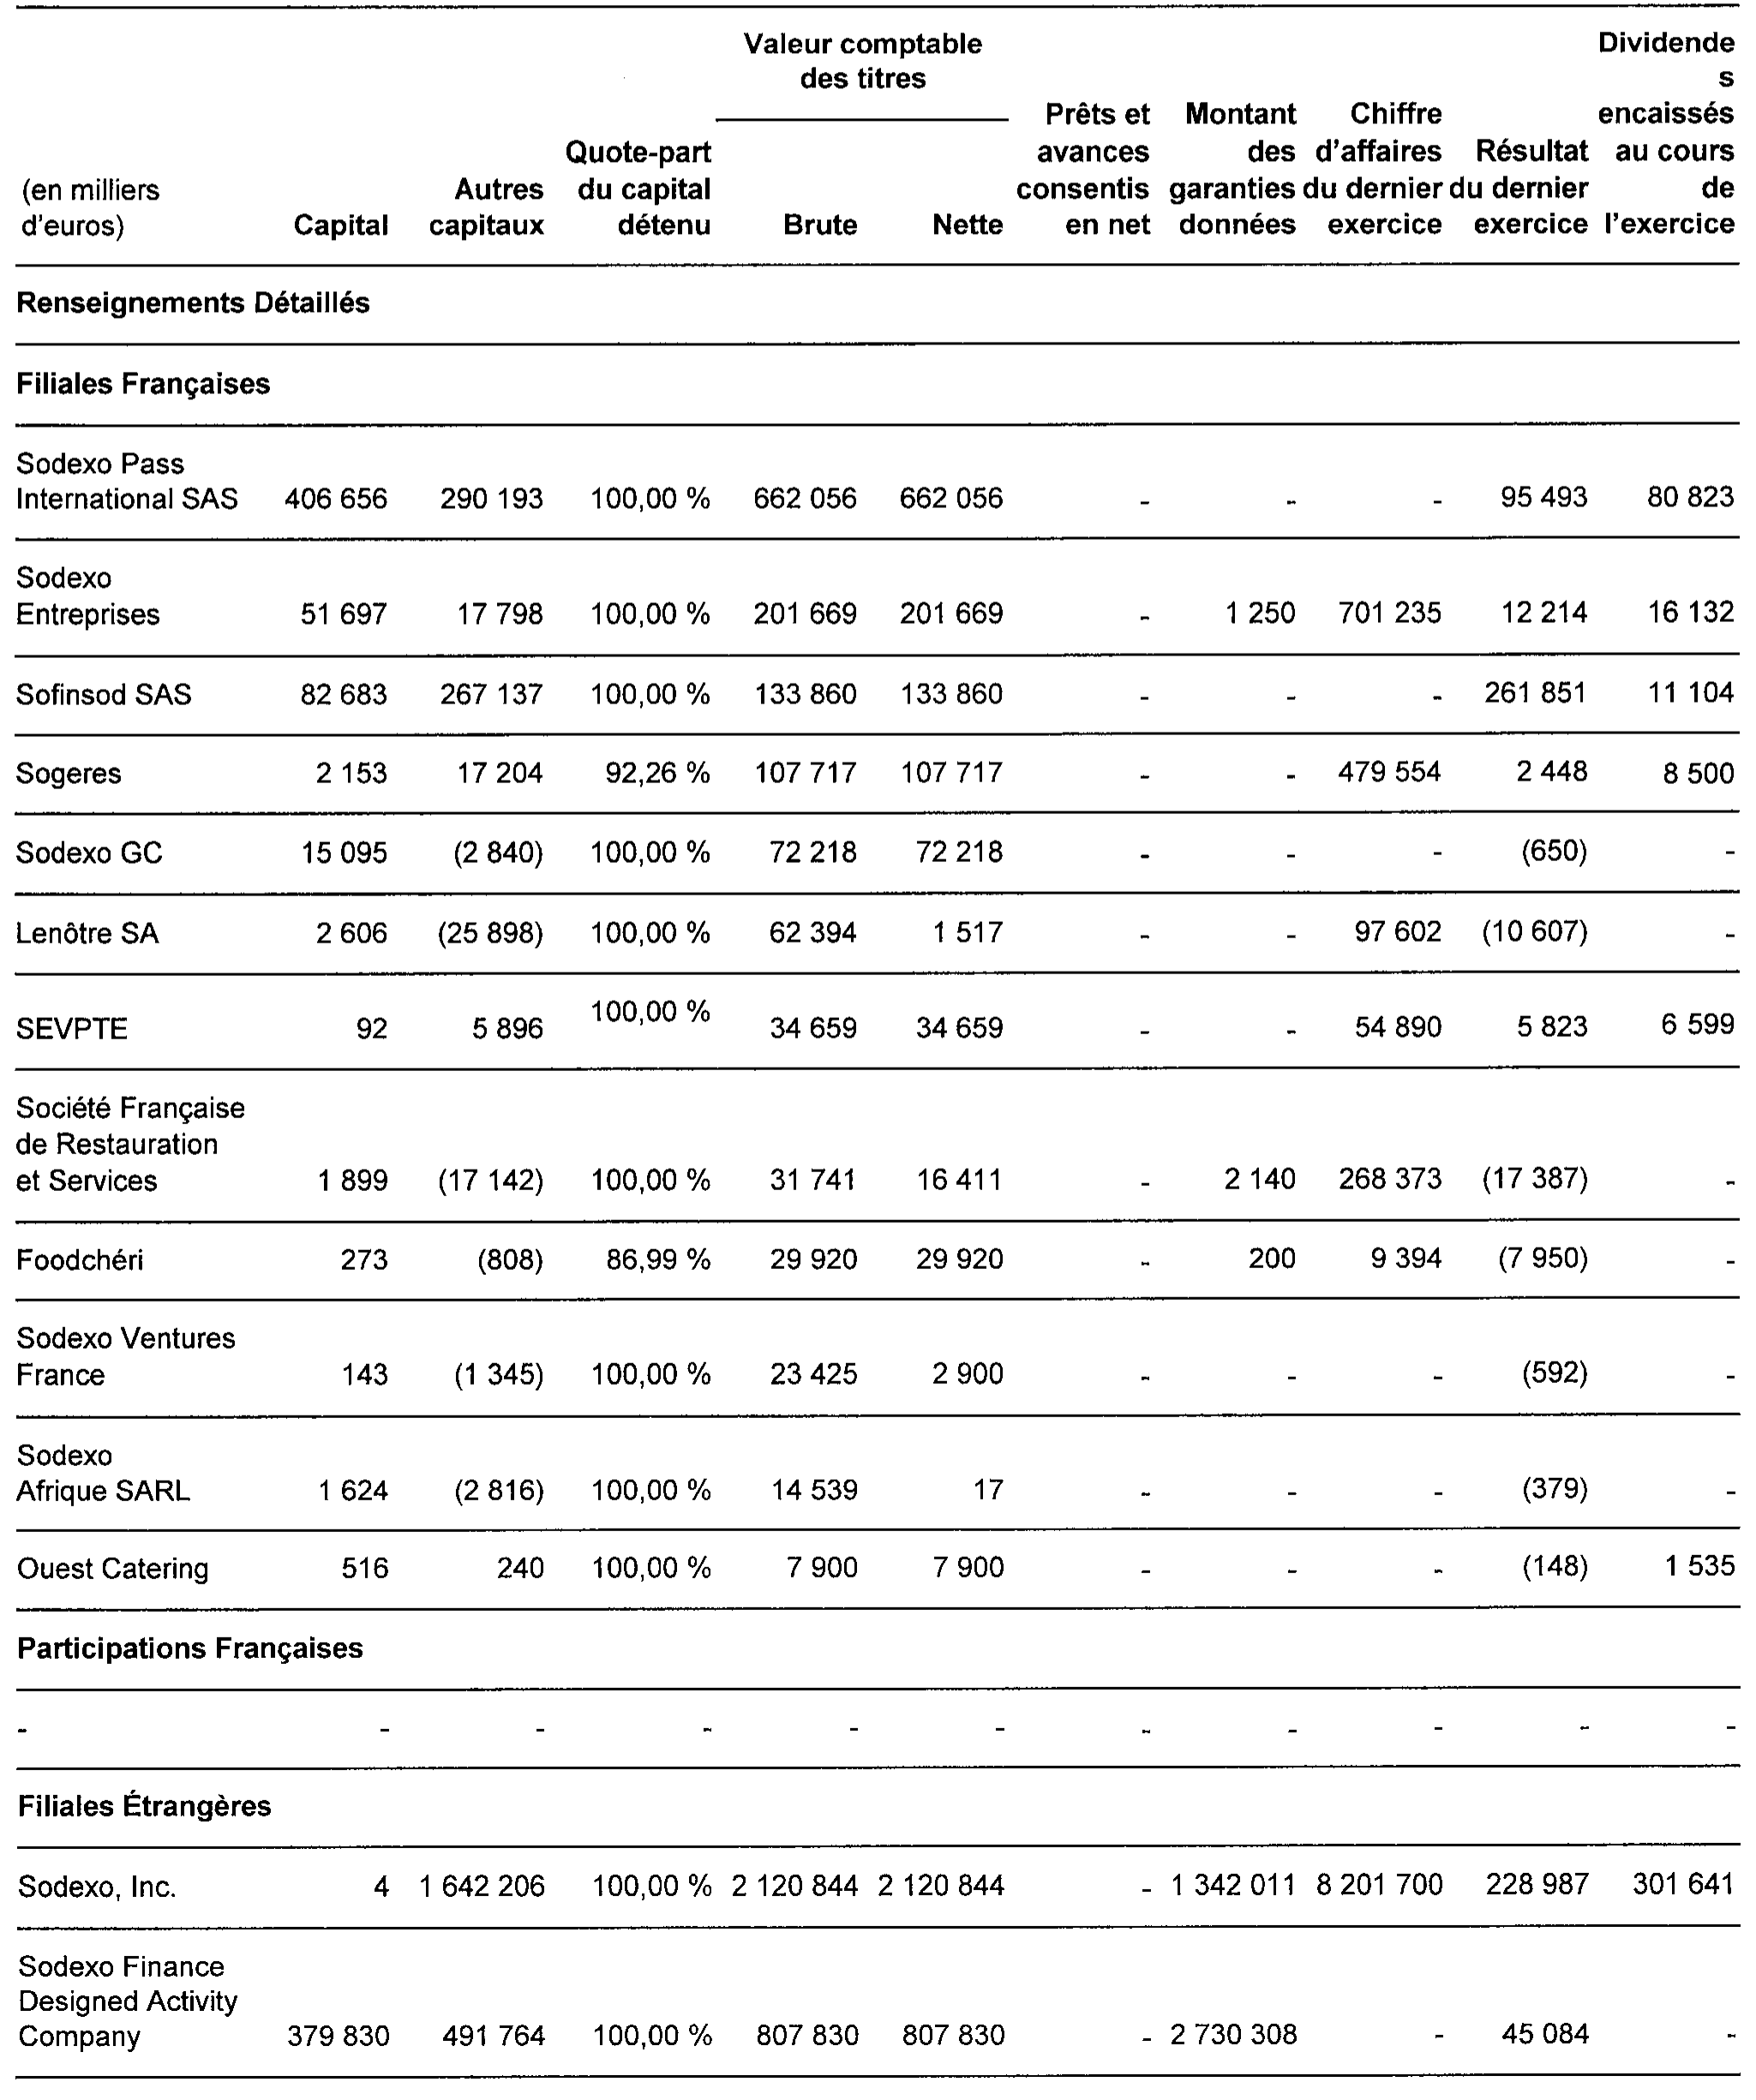

In [78]:
resized_image